# IDRNN
[Description]
(Add description here)

The goal of the project:
1. palceholder
2. placeholder


# Dataset

First download the dataset.

# Packages

In [1]:
# !pip3 install -r requirements.txt

In [39]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import  Dataset, DataLoader
import torch.nn.functional as F



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load data and print it

In [40]:
from dataloader import ProteinDataset, proteinread

In [41]:
# Replace this path with the actual path to your input CSV file
from sklearn.model_selection import train_test_split
input_csv_file = "data.csv"

# Create an instance of the ProteinDataset
train_data, val_data, seq_length = proteinread(input_csv_file)

# Create dataset instances for training and validation
train_data, val_data = ProteinDataset(train_data), ProteinDataset(val_data)

# Create data loaders for training and validation
batch_size = 1  # You can adjust this batch size
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [42]:
# pick up one sequence to show how our data looks like
g = train_data[65]

print(g)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [43]:
# to get training sequence and validation sequence only


# Create an empty list to store the numerical sequences
training_sequences = []
validation_sequences = []
# Iterate over the training_dataset and  validation dataset
for sample in train_data:
    # Extract the numerical part (the first element of the tuple) and append it to the list
    training_sequences.append(sample[0])

for sample in val_data:
    # Extract the numerical part (the first element of the tuple) and append it to the list
    validation_sequences.append(sample[0])
    
# Print the list of training sequences
print(training_sequences[65])

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


In [44]:
print(training_sequences)

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), tensor([0., 0., 0.,

# Helper function and calculation (kld reconstruct loss) and printer form tuorial 6

In [45]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [46]:
## Help function from tutroial 6 to calculate loss and plotting

def sample(mean, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std, device=mean.device)
    return mean + eps*std
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params
def plot_losses(reco_losses, kld_losses):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(reco_losses)
    ax.set_title('Reconstruction Loss')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(kld_losses)
    ax.set_title('KLD Loss')
# def generate_seq(decoder_nn, num_seq=6):
    # new_z = torch.randn(num_seq, 3)
    # if torch.cuda.is_available():
    #     new_z = new_z.cuda()

    # new_pred = decoder_nn(new_z)

    # new_pred = new_pred.cpu().detach().numpy()

    # for i in range(32):
    #     ax = fig.add_subplot(gs[i])
    #     img_array = new_pred[i][0]
    #     ax.imshow(img_array, cmap='gray')
    #     ax.axis('off')
    #     if cond:
    #         ax.set_title(f'Cond input: {rand_int[i]}')
def plot_z_dist(train_dl, encoder_nn, cond=False):
    fig = plt.figure(figsize=(24, 6))
    gs = GridSpec(1, 4)


    mus = []; log_vars = []; zs = []; ys = []
    for xb, yb, yb_one_hot in train_dl:
        if torch.cuda.is_available():
            xb = xb.cuda()
            yb_one_hot = yb_one_hot.cuda()

        if cond:
            mu, log_var = encoder_nn(xb, yb_one_hot)
        else:
            mu, log_var = encoder_nn(xb)
        z = sample(mu, log_var)

        mu = mu.cpu().detach().numpy()
        log_var = log_var.cpu().detach().numpy()
        z = z.cpu().detach().numpy()

        mus.extend(mu.tolist())
        log_vars.extend(log_var.tolist())
        zs.extend(z.tolist())
        ys.extend(yb.tolist())

    zs = np.array(zs)
    mus = np.array(mus)
    log_vars = np.array(log_vars)
    ys = np.array(ys)


    ax = fig.add_subplot(gs[0])
    ax.scatter(zs[:, 0], zs[:, 1], c=ys, cmap='tab10', alpha=0.3, s=1)
    ax.set_title('Z')
    ax.grid()
    ax.set_aspect('equal')

    gauss0 = np.random.normal(0, 1, len(zs[:, 0]))
    gauss1 = np.random.normal(0, 1, len(zs[:, 0]))
    ax = fig.add_subplot(gs[1])
    ax.scatter(gauss0, gauss1, c='cornflowerblue', alpha=0.3, s=1)
    ax.set_title('Gaus(0,1))')
    ax.set_aspect('equal')

    return ys, zs

# trainning loop based on tutorial 6

In [47]:
from model_VAE import EncoderLn, DecoderLn

hid_layer_enc = [300, 300, 200, 100]
hid_layer_dec = [300, 300, 200, 100]
latent_dim = 3
io_dim = batch_size * seq_length

encoder_nn = EncoderLn(input_dim=io_dim, hid_layer=hid_layer_enc, latent_dim=latent_dim)
decoder_nn = DecoderLn(latent_dim=latent_dim, hid_layer=hid_layer_dec, output_dim=io_dim)

# 看我派出cuda把你们都送上天！
if torch.cuda.is_available():
    encoder_nn.cuda()
    decoder_nn.cuda()

In [48]:
print(f'Encoder has {count_parameters(encoder_nn):,} trainable parameters')
print(f'Decoder has {count_parameters(decoder_nn):,} trainable parameters')

Encoder has 375,506 trainable parameters
Decoder has 180,581 trainable parameters


In [49]:

optimizer = torch.optim.Adam(list(encoder_nn.parameters()) + list(decoder_nn.parameters()), lr=0.001)


reco_losses = []
kld_losses  = []

for ep in tqdm(range(50)):
    for x in train_dataset:
        if torch.cuda.is_available():
            x = x.cuda()


        optimizer.zero_grad()

        mu, log_var = encoder_nn(x)
        z = sample(mu, log_var)

        pred = decoder_nn(z)

        # loss
        reco_loss = BCE = F.binary_cross_entropy(pred, x, reduction='sum')
        kld_loss  = -0.5 * torch.sum(1 + log_var - mu**2 -  log_var.exp())

        loss = reco_loss + kld_loss

        loss.backward()
        optimizer.step()

        reco_losses.append(reco_loss.item())
        kld_losses.append(kld_loss.item())


100%|██████████| 50/50 [40:18<00:00, 48.37s/it]


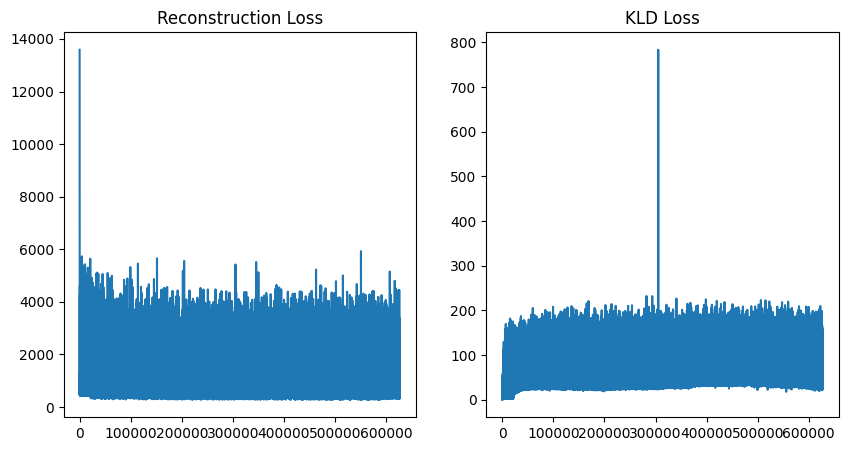

In [50]:
plot_losses(reco_losses, kld_losses)

In [41]:
tmp = decoder_nn(torch.FloatTensor([-0.2, 0.8, 0.2]).cuda())
print(tmp)

tensor([2.0762e-02, 7.1480e-03, 1.2840e-02, 2.0705e-02, 9.7823e-03, 3.0641e-02,
        6.2582e-03, 7.3028e-03, 1.9020e-02, 1.3078e-02, 7.6614e-03, 1.2712e-02,
        9.8776e-05, 7.9267e-03, 1.5527e-02, 5.8936e-04, 1.7666e-02, 1.0826e-02,
        3.5874e-03, 6.3784e-03], device='cuda:0', grad_fn=<SigmoidBackward0>)
